In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
jpg_folder_path = 'F:\ARIK\Foto Arik\Datasets_acne'

# List of file names in the folder
file_names = os.listdir(jpg_folder_path)

# Iterate over the file names and load each JPG file
images = []
for file_name in file_names:
    file_path = os.path.join(jpg_folder_path, file_name)
    if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):  
        img = Image.open(file_path)
        images.append(img)


In [4]:
# List to store the images
images = []

# List to store the corresponding labels
labels = []

label_mapping = {
    'Level_1': 1,
    'Level_2': 2,
    'Level_3': 3,
    'Level_4': 4
}
# Iterate over the subdirectories (folders) in the jpg_folder_path
for subdir in os.listdir(jpg_folder_path):
    subdir_path = os.path.join(jpg_folder_path, subdir)
    
    # Check if the subdirectory is a folder
    if os.path.isdir(subdir_path):
        # Iterate over the file names in the subdirectory
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            
            if file_path.endswith('.jpg') or file_path.endswith('.jpeg'): 
                img = Image.open(file_path)
                images.append(img)
                labels.append(subdir) 



In [5]:
print(len(images))  # Print the number of loaded images
print(len(labels))  # Print the number of corresponding labels

1339
1339


In [6]:
# Reshape and normalize the images
resized_images = [img.resize((128, 128)) for img in images]
normalized_images = [np.array(img) / 255.0 for img in resized_images]


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

# Generate augmented images
augmented_images = []
for img in normalized_images:
    img = np.expand_dims(img, axis=0) 
    augmented_img = datagen.flow(img, batch_size=126)[0][0]
    augmented_images.append(augmented_img)

In [7]:
train_folder = 'F:\ARIK\Foto Arik\Dataset_acne_train'
test_folder = 'F:\ARIK\Foto Arik\Dataset_acne_test'

# Create the training and testing directories 
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over the subdirectories in the dataset folder
for subfolder in os.listdir(jpg_folder_path):
    subfolder_path = os.path.join(jpg_folder_path, subfolder)
    train_subfolder_path = os.path.join(train_folder, subfolder)
    test_subfolder_path = os.path.join(test_folder, subfolder)

    if subfolder != ".DS_Store": 
        
        
        os.makedirs(train_subfolder_path, exist_ok=True)
        os.makedirs(test_subfolder_path, exist_ok=True)

        # Get the list of image files in the subdirectory
        image_files = [file for file in os.listdir(subfolder_path) if file.endswith('.jpg') or file.endswith('.jpeg')]

        # Shuffle the image files randomly
        random.shuffle(image_files)

        # Split the image files into training and testing subsets (80:20 ratio)
        split_index = int(0.8 * len(image_files))
        train_files = image_files[:split_index]
        test_files = image_files[split_index:]

        # Move the training files to the corresponding subdirectory in the training folder
        for train_file in train_files:
            src_path = os.path.join(subfolder_path, train_file)
            dst_path = os.path.join(train_subfolder_path, train_file)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)

        # Move the testing files to the corresponding subdirectory in the testing folder
        for test_file in test_files:
            src_path = os.path.join(subfolder_path, test_file)
            dst_path = os.path.join(test_subfolder_path, test_file)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)

# Print the paths of the training and testing folders
print("Training folder:", train_folder)
print("Testing folder:", test_folder)


Training folder: F:\ARIK\Foto Arik\Dataset_acne_train
Testing folder: F:\ARIK\Foto Arik\Dataset_acne_test


In [8]:
# Define the path to your dataset folder
dataset_folder = jpg_folder_path 

# Define the parameters for the image dataset
image_size = (128, 128)  
batch_size = 126

# Create the labeled image dataset using the directory structure
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'  
)

# Print the class names and the number of classes
class_names = image_dataset.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)


Found 1339 files belonging to 4 classes.
Class names: ['Level_1', 'Level_2', 'Level_3', 'Level_4']
Number of classes: 4


## MODEL

In [9]:

# Load the MobileNet pre-trained model
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Create a new sequential model
model = Sequential()

# Add the MobileNet model as the base
model.add(mobilenet)

# Add a global average pooling layer
model.add(GlobalAveragePooling2D())

# Add a dense layer for the output
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 3,232,964
Trainable params: 3,211,076
Non-trainable params: 21,888
_________________________________________________________________


In [10]:

TRAINING_DIR = 'F:\ARIK\Foto Arik\Dataset_acne_train'
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = 'F:\ARIK\Foto Arik\Dataset_acne_test'
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=126
)


Found 1070 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [11]:

# Set the number of training and validation steps
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = validation_generator.n // validation_generator.batch_size

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch
)


C:\Users\arikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 55s 6s/step - loss: 1.4465 - accuracy: 0.4206 - val_loss: 2.0596 - val_accuracy: 0.3214
Epoch 2/100
8/8 [==============================] - 43s 5s/step - loss: 0.8892 - accuracy: 0.6123 - val_loss: 2.4433 - val_accuracy: 0.3214
Epoch 3/100
8/8 [==============================] - 45s 6s/step - loss: 0.7864 - accuracy: 0.6600 - val_loss: 2.1659 - val_accuracy: 0.3611
Epoch 4/100
8/8 [==============================] - 43s 6s/step - loss: 0.7067 - accuracy: 0.6928 - val_loss: 1.9600 - val_accuracy: 0.3492
Epoch 5/100
8/8 [==============================] - 43s 5s/step - loss: 0.6357 - accuracy: 0.7129 - val_loss: 1.7651 - val_accuracy: 0.3452
Epoch 6/100
8/8 [==============================] - 46s 6s/step - loss: 0.5947 - accuracy: 0.7203 - val_loss: 1.6422 - val_accuracy: 0.3810
Epoch 7/100
8/8 [==============================] - 44s 5s/step - loss: 0.5535 - accuracy: 0.7585 - val_loss: 1.7929 - val_accuracy: 0.3730
Epoch 8/100
8/8 [==========

In [12]:
# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the training history to a CSV file
history_df.to_csv('training_history.csv', index=False)

In [13]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_steps_per_epoch)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


8/8 [==============================] - 19s 2s/step - loss: 0.0717 - accuracy: 0.9752
Training Loss: 0.07171811163425446
Training Accuracy: 0.9751983880996704


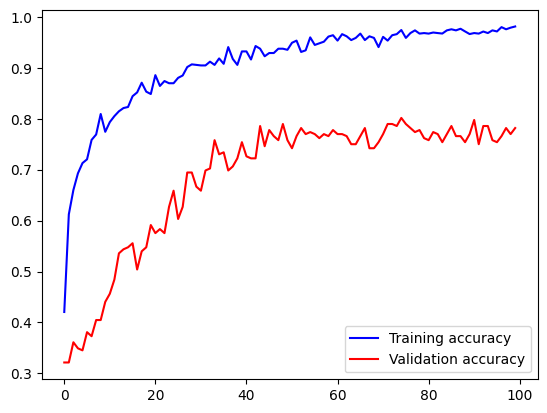

<Figure size 640x480 with 0 Axes>

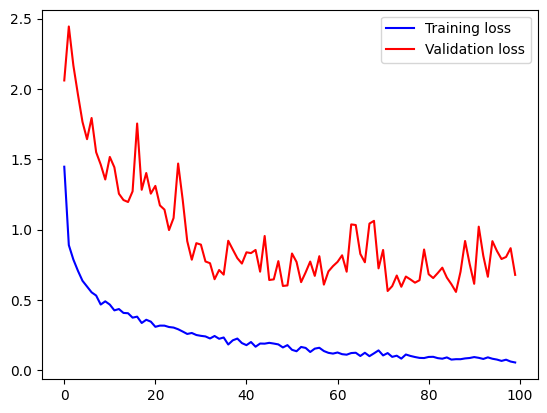

<Figure size 640x480 with 0 Axes>

In [14]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [17]:


# Load an image for prediction
image_path = 'F:\ARIK\Foto Arik\Dataset_acne_test\Level_2\level2_(9).jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128, 3))  # Resize to (224, 224)
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0  # Normalize the image

# Reshape the image to match the input shape expected by the model
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = model.predict(image)

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Print the predicted class label
print("Predicted class:", predicted_class)


1/1 [==============================] - 1s 575ms/step
Predicted class: 1


In [21]:
print(validation_generator.classes)
num_test_images = 1069
# Y_pred = finetune_model.predict_generator(validation_generator, num_test_images // BATCH_SIZE+1)
Y_pred = model.predict_generator(validation_generator, num_test_images)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('\nClassification Report')
target_names = ['Level_1', 'Level_2', 'Level_3', 'Level_4']
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3]


C:\Users\arikr\AppData\Local\Temp\ipykernel_5112\1592910705.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_test_images)


Confusion Matrix
[[37 12 11 18]
 [30  8 16 21]
 [19  7 10 14]
 [28 18 10 10]]

Classification Report
              precision    recall  f1-score   support

     Level_1       0.32      0.47      0.39        78
     Level_2       0.18      0.11      0.13        75
     Level_3       0.21      0.20      0.21        50
     Level_4       0.16      0.15      0.16        66

    accuracy                           0.24       269
   macro avg       0.22      0.23      0.22       269
weighted avg       0.22      0.24      0.23       269



In [23]:
model.save("acnelevel.h5")